In [2]:
# Necessary Imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Set the directory where your data is stored
data_dir = '../data/EuroSAT_RGB'

# Set the batch size for training and testing
batch_size = 4

# Define a transformation to apply to the images
transform = transforms.Compose(
    [transforms.Resize((32, 32)),  # Resize images to 32x32
     transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize the images

# Load the training data
dataset = ImageFolder(root=data_dir, transform=transform)

# Create data loaders for training and testing datasets
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print some samples to verify the data loading
data_iter = iter(data_loader)
images, labels = data_iter.next()
print(images.shape, labels.shape)


torch.Size([4, 3, 32, 32]) torch.Size([4])


In [4]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


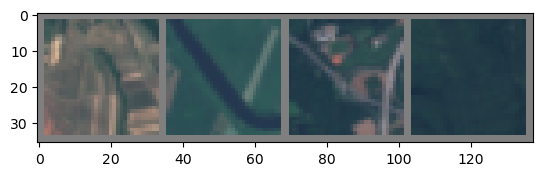

PermanentCrop River Highway Forest


In [6]:
# Get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % dataset.classes[labels[j]] for j in range(batch_size)))


In [8]:
# Necessary Imports
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Splitting the data into train and test
split_ratio = 0.8  # 80% for training and 20% for testing
data_length = len(dataset)
train_len = int(split_ratio * data_length)
test_len = data_length - train_len
train_dataset, test_dataset = random_split(dataset, lengths=[train_len, test_len])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Defining a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # input channels = 3, output channels = 6, kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(dataset.classes))  # output size = number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the CNN
net = Net()

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Visualize some test set images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % dataset.classes[labels[j]] for j in range(batch_size)))

# Get predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % dataset.classes[predicted[j]]
                              for j in range(batch_size)))
